In [1]:
import pandas as pd
from umap import UMAP
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

DATA_FILE = 'ingredient_data.csv'

In [2]:
df = pd.read_csv(DATA_FILE)
df.shape

(145087, 15)

In [7]:
# Various experimental dataset modifications

# replaces each quantity with its ratio to flour
df2 = df.copy()
for c in df2.columns:
    if c == 'flour' or c == 'category':
        continue
    df2[c] = df2[c]/df2['flour']
df2.drop(columns='flour', inplace=True)
df2.drop(index=df2.loc[df2['sugar'] > 5].index, inplace=True)
df2.reset_index(drop=True, inplace=True)

# remove likely malformed inputs (recipes that have 5 times as much sugar as flour)
df['s2f'] = df['sugar'] / df['flour']
df.drop(index=df.loc[df['s2f'] > 5].index, inplace=True)
df.drop(columns='s2f', inplace=True)
df.reset_index(drop=True, inplace=True)

# remove muffins
df_no_m = df.drop(index=df.loc[df['category'] == 'muffin'].index).reset_index(drop=True)

# remove recipes with no sugar
df_s = df.drop(index=df.loc[df['sugar'] == 0].index).reset_index(drop=True)

In [10]:
current_df = df
pca2c = PCA(n_components=2)
mypcs = pd.DataFrame(pca2c.fit_transform(current_df.drop(columns='category')), columns=['pc1', 'pc2'])

<Axes: xlabel='pc1', ylabel='pc2'>

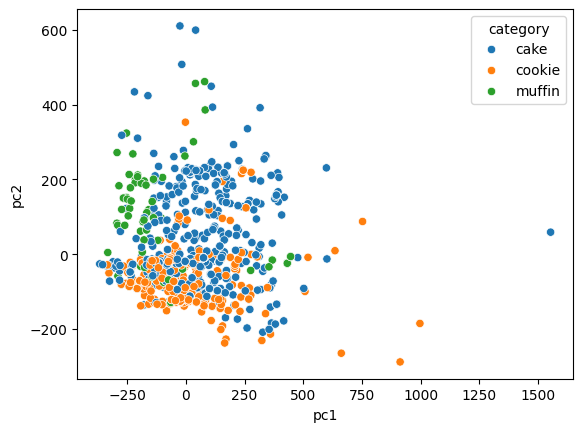

In [11]:
# limited to first 1000 points to reduce clutter
sns.scatterplot(data=mypcs.iloc[:1000], x='pc1', y='pc2', hue=current_df['category'].iloc[:1000])

In [12]:
current_df = df
umaptf = UMAP(min_dist=0.1, n_neighbors=5)
umapembedding = pd.DataFrame(umaptf.fit_transform(current_df.drop(columns='category').iloc[:1000]), columns=['d1', 'd2'])

<Axes: xlabel='d1', ylabel='d2'>

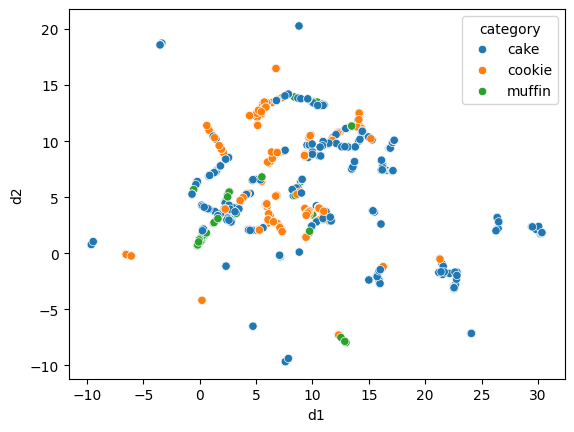

In [13]:
sns.scatterplot(data=umapembedding, x='d1', y='d2', hue=current_df['category'].iloc[:1000])

In [14]:
# kNN without any data transformation, as a control
# uses data points 0-2999 as training, 3000-3999 as test
current_df = df
knn = KNeighborsClassifier(n_neighbors=25, weights='distance').fit(current_df.drop(columns='category').iloc[:3000], current_df['category'].iloc[:3000])
knn.score(current_df.drop(columns='category').iloc[3000:4000], current_df['category'].iloc[3000:4000])

0.837

In [18]:
# transform some data points with UMAP, same train/test as above
current_df = df
umaptf = UMAP(min_dist=0.1, n_neighbors=70, random_state=99, n_jobs=1)
transformer = umaptf.fit(current_df.drop(columns='category').iloc[:3000])
embedding = transformer.transform(current_df.drop(columns='category').iloc[3000:4000])

In [19]:
# evaluate UMAP embedding with kNN
knn = KNeighborsClassifier(n_neighbors=15, weights='distance').fit(transformer.embedding_, current_df['category'].iloc[:3000])
knn.score(embedding, current_df['category'].iloc[3000:4000])

0.814

<Axes: xlabel='d1', ylabel='d2'>

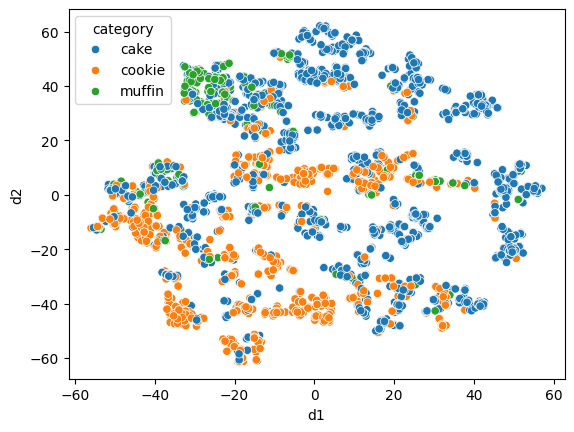

In [20]:
current_df = df
tsne_model = TSNE(n_components=2, perplexity=50)
tse = tsne_model.fit_transform(current_df.drop(columns='category').iloc[:5000])
tse = pd.DataFrame(tse, columns=['d1','d2'])
sns.scatterplot(data=tse, x='d1', y='d2', hue=current_df['category'])